In [91]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [92]:
# data parameters
n_monto_carlo = 10 ** 5
risky_asset = ['TSLA', 'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META']
start_date = '2018-01-01'
end_date = '2024-01-01'

n_assets = len(risky_asset)

In [93]:
# download the data
prices_df = yf.download(risky_asset, start=start_date, end=end_date)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
prices_df.head(3)

[*********************100%%**********************]  7 of 7 completed

Downloaded 1509 rows of data.


Price       Adj Close                                                          \
Ticker           AAPL       AMZN       GOOG        META       MSFT       NVDA   
Date                                                                            
2018-01-02  40.615883  59.450500  53.250000  181.227707  79.936737  49.310482   
2018-01-03  40.608810  60.209999  54.124001  184.474274  80.308739  52.555786   
2018-01-04  40.797436  60.479500  54.320000  184.134628  81.015587  52.832832   

Price                      Close                        ...       Open  \
Ticker           TSLA       AAPL       AMZN       GOOG  ...       MSFT   
Date                                                    ...              
2018-01-02  21.368668  43.064999  59.450500  53.250000  ...  86.129997   
2018-01-03  21.150000  43.057499  60.209999  54.124001  ...  86.059998   
2018-01-04  20.974667  43.257500  60.479500  54.320000  ...  86.589996   

Price                                Volume                                \
Ticker           NVDA       TSLA       AAPL      AMZN      GOOG      META   
Date                                                                        
2018-01-02  48.945000  20.799999  102223600  53890000  24752000  18151900   
2018-01-03  51.025002  21.400000  118071600  62176000  28604000  16886600   
2018-01-04  53.939999  20.858000   89738400  60442000  20092000  13880900   

Price                                      
Ticker          MSFT      NVDA       TSLA  
Date                                       
2018-01-02  22483800  35561600   65283000  
2018-01-03  26061400  91470400   67822500  
2018-01-04  21912000  58326800  149194500  

[3 rows x 42 columns]

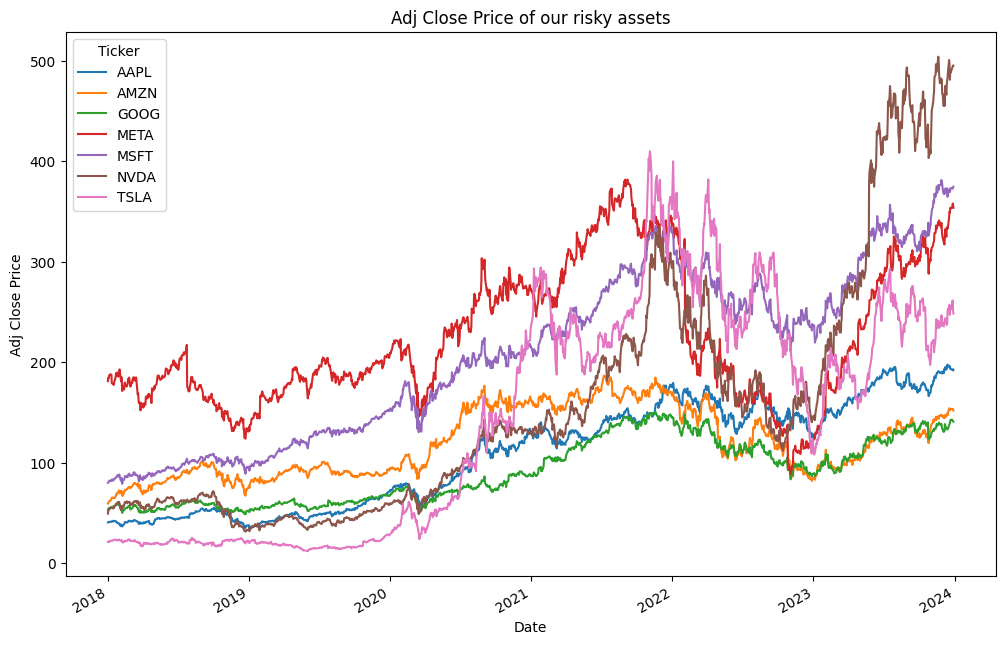

In [94]:
# choose Adj Close
prices_df['Adj Close'].plot(title='Adj Close Price of our risky assets')
plt.ylabel('Adj Close Price')
plt.show()

In [95]:
# caculate the percentage returns
returns_df = prices_df['Adj Close'].pct_change().dropna()
returns_df.head()

Ticker,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA
Date,,,,,,,
2018-01-03,-0.000174,0.012775,0.016413,0.017914,0.004654,0.065814,-0.010233
2018-01-04,0.004645,0.004476,0.003621,-0.001841,0.008802,0.005271,-0.008290
2018-01-05,0.011386,0.016163,0.014571,0.013671,0.012398,0.008474,0.006230
2018-01-08,-0.003714,0.014425,0.004273,0.007653,0.001020,0.030640,0.062638
2018-01-09,-0.000115,0.004676,-0.000614,-0.002178,-0.000680,-0.000270,-0.008085


In [96]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(Ticker
 AAPL    1.855747
 AMZN    1.313482
 GOOG    1.266359
 META    1.227152
 MSFT    1.818217
 NVDA    3.099012
 TSLA    3.670944
 dtype: float64,
 Ticker      AAPL      AMZN      GOOG      META      MSFT      NVDA      TSLA
 Ticker                                                                      
 AAPL    0.600865  0.418595  0.399269  0.464245  0.428472  0.621085  0.562048
 AMZN    0.418595  0.748981  0.446456  0.549797  0.444354  0.661097  0.571278
 GOOG    0.399269  0.446456  0.583868  0.531880  0.430312  0.604096  0.474346
 META    0.464245  0.549797  0.531880  1.095162  0.470291  0.716793  0.556137
 MSFT    0.428472  0.444354  0.430312  0.470291  0.543388  0.644006  0.510731
 NVDA    0.621085  0.661097  0.604096  0.716793  0.644006  1.580205  0.921640
 TSLA    0.562048  0.571278  0.474346  0.556137  0.510731  0.921640  2.434880)

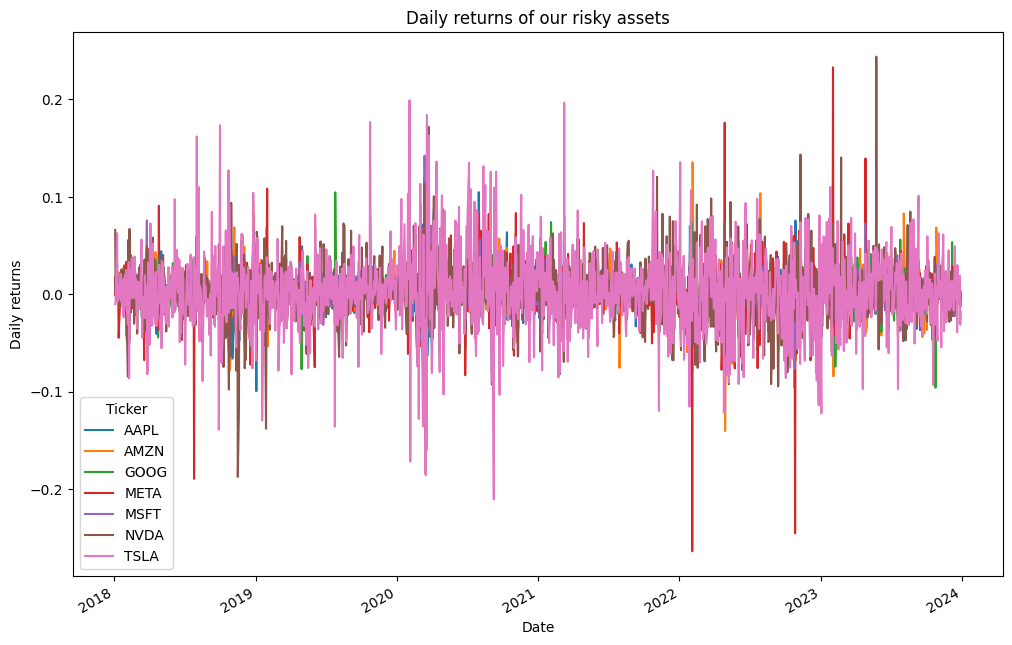

In [97]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [98]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [99]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [100]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [101]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

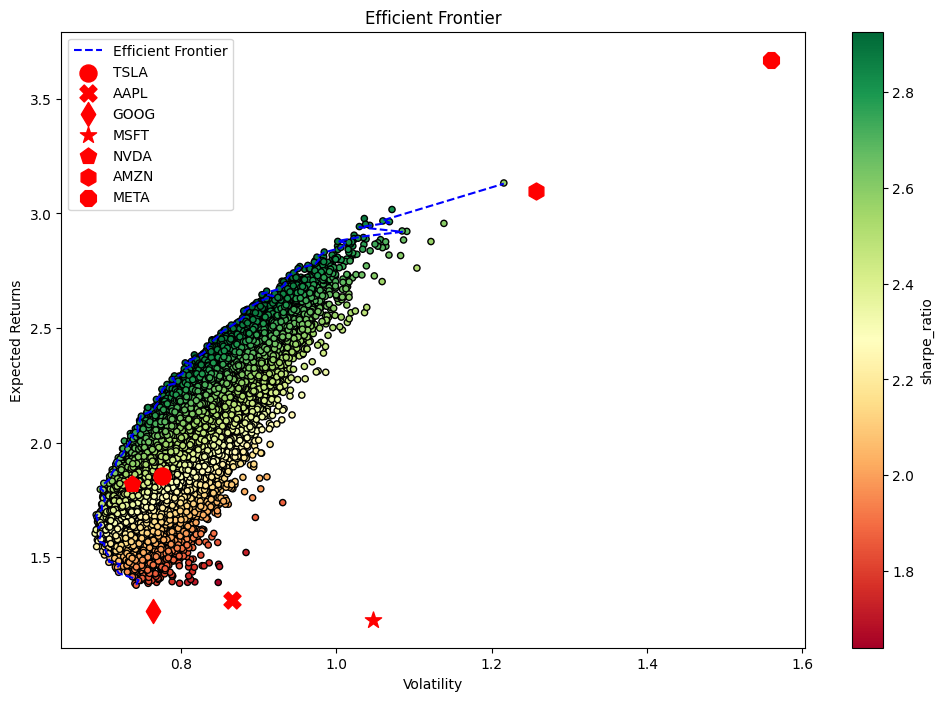

In [110]:
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

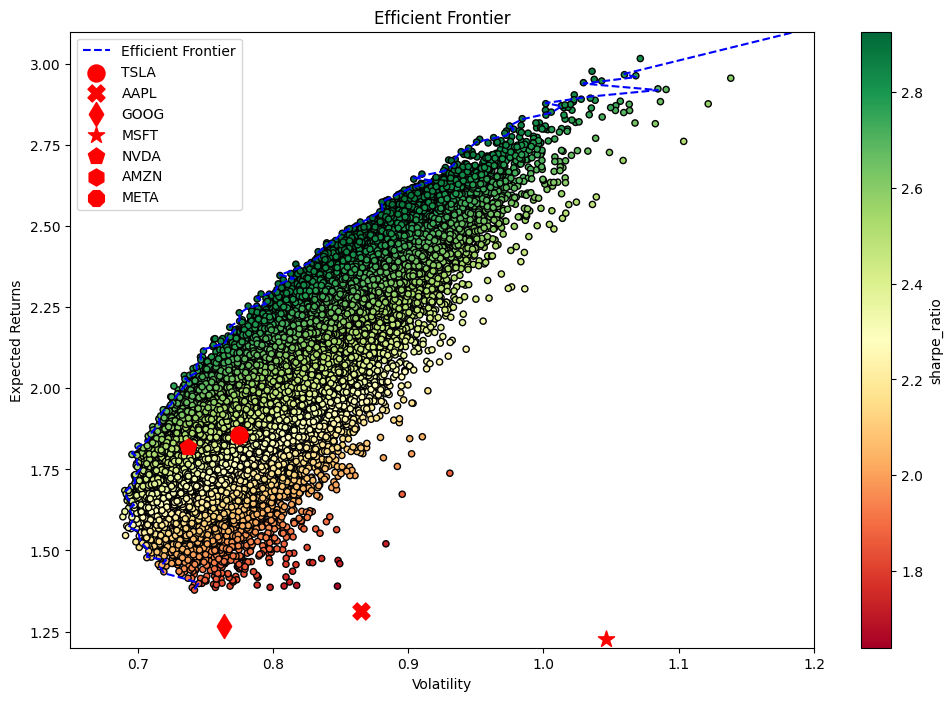

In [111]:
# a bigger figure
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier',\
       xlim = (0.65, 1.2), ylim = (1.2, 3.1))
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

In [104]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [105]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 264.55% volatility: 90.41% sharpe_ratio: 292.62% 
Weights:
TSLA: 21.71% AAPL: 2.93% GOOG: 0.32% MSFT: 0.01% NVDA: 22.94% AMZN: 22.61% META: 29.48% 

In [106]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 160.39% volatility: 68.91% sharpe_ratio: 232.76% 
Weights:
TSLA: 15.63% AAPL: 10.91% GOOG: 32.74% MSFT: 1.88% NVDA: 37.37% AMZN: 0.11% META: 1.37% 

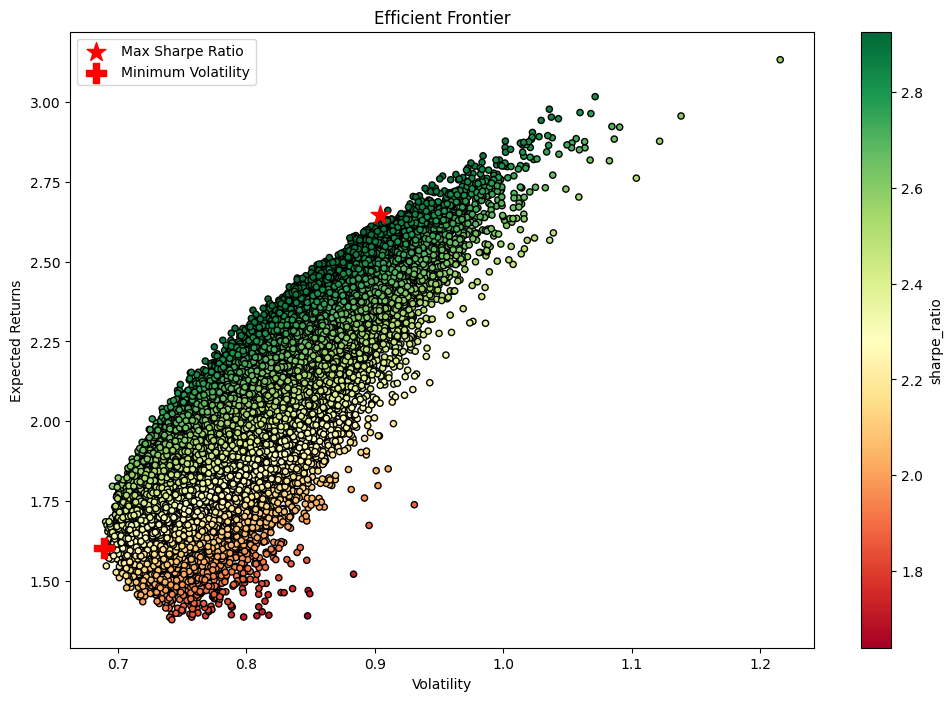

In [108]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()